In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use(r'mplstyle')

import matplotlib as mpl
import pandas as pd
from sklearn.svm import SVC
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from scipy.optimize import minimize

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fec787', '#fb9d32']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [4]:
def fit_svc(data, label):
    svc = SVC(kernel = 'linear', class_weight = 'balanced')
    svc.fit(data, label)
    w = svc.coef_[0]           # w consists of 2 elements
    a = - svc.intercept_[0] / w[1]
    b = - w[0] / w[1]
    return a, b

def analyse_loglog_data(xx, yy, label, repeats = 50, nsample = 5000):
    # fit power law
    lnx = np.log10(xx)
    lny = np.log10(yy)
    data = np.array([lnx, lny]).T
    
    molar_ratio = []
    B = []
    A = []
    for _ in range(repeats):
        print(_, end = '\r')
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        # a, b = fit_crosstalk(data_resampled, label_resampled, x0 = [b, a])
        molar_ratio.append(-1/b)
        B.append(b)
        A.append(a)
    molar_ratio_avg = np.mean(molar_ratio)
    molar_ratio_std = np.std(molar_ratio)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std]

def fit_crosstalk(data, label, x0 = [1, 1]):
    def crosstalk(params):
        k = params[0]
        y = params[1]
        cost = 0
        gBottom = data[label == False]
        gTop = data[label == True]
        BottomInTop = gBottom[gBottom[:, 1] > y + k * gBottom[:, 0]]
        TopInBottom = gTop[gTop[:, 1] < y + k * gTop[:, 0]]
        cost += sum(abs((BottomInTop[:, 1] - (y + k * BottomInTop[:, 0]))))
        cost += sum(abs((TopInBottom[:, 1] - (y + k * TopInBottom[:, 0]))))
        return cost
    res = minimize(crosstalk, x0 = x0)
    [_k, _y] = res.x
    return _y, _k

def analyse_linlog_data(xx, yy, label, repeats = 50, nsample = 5000):

    lny = np.log(yy)
    data = np.array([xx, lny]).T
    
    B = []
    A = []
    for _ in range(repeats):
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        # in this script we perform a second step of minimising the cross-talk between the two groups of points
        # this is due to the sparsity of data - SVM performs poorly in this case
        a, b = fit_crosstalk(data_resampled, label_resampled, x0 = [b, a])
        B.append(b)
        A.append(a)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [A_avg, A_std, B_avg, B_std]

In [5]:
df = pd.read_csv('../data/Whi3_Lin.csv').sample(frac = 1)

In [6]:
df.columns

Index(['Whi3 (uM)', 'RNA (uM)', 'RNA type', 'feature'], dtype='object')

In [7]:
RNAs = [#'CLN3',
        'BNI1',
        'BNI1 mutant',
        #'SPA2'
        ]
RNALen = [#1594,
          6689,
          6689,
          #10908,
         ]
xName = 'Whi3 (uM)'
yName = 'RNA (uM)'

In [8]:
RES = []
for i in range(len(RNAs)):
    _df = df[df['RNA type'] == RNAs[i]]
    _x = _df[xName].values
    _y = _df[yName].values
    _p = _df['feature'].values
    _mask = (_x < 100) & (_y < 0.1)
    
    res = analyse_loglog_data(_x[_mask], _y[_mask], _p[_mask], repeats = 50, nsample = int(sum(_mask)))
    print(r'For {0}, molar ratio of {1} against {2} is {3:.3f}+-{4:.3f}'.format(RNAs[i], yName, xName, res[0], res[1]))
    RES.append([_x, _y, _p, res])

For BNI1, molar ratio of RNA (uM) against Whi3 (uM) is 1.751+-0.485
For BNI1 mutant, molar ratio of RNA (uM) against Whi3 (uM) is 0.732+-0.179


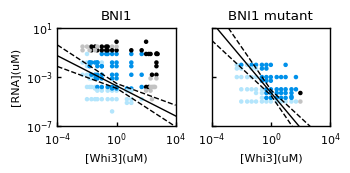

In [9]:
fig, axes = plt.subplots(1, len(RNAs), sharex = True, sharey = True, figsize = cm2inch(9, 4.5))

for i in range(len(RNAs)):
    _df = df[df['RNA type'] == RNAs[i]]
    _x = _df[xName].values
    _y = _df[yName].values
    _p = _df['feature'].values

    _mask = (_x < 100) & (_y < 0.1)
    _c = [colors[0][j] for j in _p.astype(int)[_mask]]
    _c2 = [[colors[4][0], 'black'][j] for j in _p.astype(int)[_mask == False]]
    
    axes[i].scatter(_x[_mask], _y[_mask], c = _c, s = 5)
    axes[i].scatter(_x[_mask == False], _y[_mask == False], c = _c2, s = 5)

    [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std] = RES[i][3]
    x_fit = np.logspace(-4, 4, 500)
    y_fit_avg = 10 ** A_avg * x_fit ** B_avg
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(10 ** (A_avg + _1 * A_std) * x_fit ** (B_avg + _2 * B_std))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)
    
    axes[i].plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    axes[i].plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    axes[i].plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')
    
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel(r'[Whi3](uM)')
    #line, = axes[i].plot([1e-4, 1e2, 1e2], [1e-1, 1e-1, 1e-7], color = 'black', linestyle = 'dashed')
    #line.set_dashes([1.5, 2.4])
    #line.set_dash_capstyle('round')
    
    axes[i].set_title(f'{RNAs[i]}')#, $L$ = {RNALen[i]}')
    axes[i].set_xticks([1e-4, 1e0, 1e4])

axes[0].set_yticks([1e-7, 1e-3, 1e1])

axes[0].set_xlim(1e-4, 1e4)
axes[0].set_ylim(1e-7, 1e1)

axes[0].set_ylabel(r'[RNA](uM)')
plt.tight_layout()
plt.savefig('plots/Whi3Lin_fitting.pdf')

In [10]:
Y = []
dY = []
for i in range(len(RNAs)):
    res = RES[i][3]
    Y.append(res[0])
    dY.append(res[1])
Y = np.array(Y)
dY = np.array(dY)

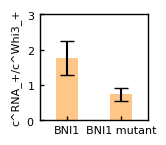

In [12]:
plt.figure(figsize = cm2inch(4.2, 3.8))
plt.bar(np.arange(len(RNAs)), Y, yerr = dY, capsize = 5, color = colors[2][0],
        width = 0.4)

plt.ylim(0,3)
plt.yticks(np.arange(4))
plt.xlim(-0.5, len(RNAs) - 0.5)

plt.xticks(np.arange(len(RNAs)), RNAs)# [r'$\textbf{a}$', r'$\textbf{b}$', r'$\textbf{c}$'])
plt.ylabel(r'c^RNA_+/c^Whi3_+')
plt.tight_layout()
plt.savefig('plots/Whi3Lin_barplot.pdf')

In [13]:
df2 = pd.read_csv('../data/Whi3_Zhang.csv').sample(frac = 1)

In [14]:
x2 = df2['CLN3(uM)'].values
y2 = df2['Whi3(uM)'].values
p2 = df2['feature'].values
c2 = [colors[0][j] for j in p2.astype(int)]

In [15]:
res = analyse_linlog_data(x2, y2, p2, repeats = 10)
[A_avg, A_std, B_avg, B_std] = res

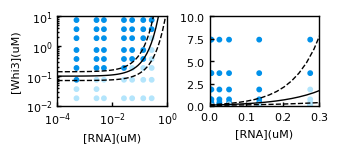

In [16]:
fig, axes = plt.subplots(1, 2, figsize = cm2inch(8.7, 4))
lin_grid = np.linspace(0, 1)
log_grid = np.logspace(-4, 0)
for i in range(2):
    s_grid = lin_grid if i else log_grid
    axes[i].scatter(x2, y2, c = c2, s = 10, zorder = -100)

    
    y_fit_avg = np.exp(A_avg + B_avg * s_grid)
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(np.exp(A_avg + _1 * A_std + s_grid * (B_avg + _2 * B_std)))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)

    axes[i].plot(s_grid, np.exp(A_avg + B_avg * s_grid), color = 'black', lw = 1)
    axes[i].plot(s_grid, y_fit_max, color = 'black', linestyle = 'dashed', lw = 1)
    axes[i].plot(s_grid, y_fit_min, color = 'black', linestyle = 'dashed', lw = 1)
    axes[i].set_xlabel(r'[RNA](uM)')
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_xlim(1e-4, 1e0)
axes[0].set_ylim(1e-2, 1e1)
axes[1].set_xlim(0, 0.3)
axes[1].set_ylim(0, 10)
axes[0].set_ylabel(r'[Whi3](uM)')
plt.tight_layout()
plt.savefig('plots/Whi3Zhang_fitting.pdf')

In [17]:
print(np.exp(A_avg))
print(np.exp(A_avg + A_std) - np.exp(A_avg))
print(B_avg)
print(B_std)

0.09907719285378876
0.03983780936099933
9.46923934932173
3.890946053441943
